In [1]:
# V7
# histogram inputs and outputs
# inputs not normalized (yet?)
# manually split the set , do nooot use train_test_split

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

2023-09-19 09:25:39.250093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions

In [2]:
#return gammas back to original values in order to plot EOS

#γ0 ∈ [0.2, 2.0]
#γ1 ∈ [−1.6, 1.7]
#γ2 ∈ [−0.6, 0.6]
#γ3 ∈ [−0.02, 0.02]

def unnorm(gammaarray):
    
    for i in range (len(gammaarray)):
        new_gamma0_array = gammaarray[0]  * ( 2.0 - 0.2 ) + 0.2
        new_gamma1_array = gammaarray[1] * 1.7
        new_gamma2_array = gammaarray[2] * 0.6
        new_gamma3_array = gammaarray[3] * 0.02

    new_gamma_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_gamma3_array), axis=1)

    return new_gamma_array
    

In [3]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    gamma3 = data.pop('gamma3')
    gamma3 = np.array(gamma3)
    return gamma0, gamma1, gamma2, gamma3


In [4]:
def whiten(df):
    
    df_new = pd.DataFrame()
    for k in df.keys():
        df_new[k] = (df[k]-np.mean(df[k])) / np.std(df[k])
    return df_new

    #return (x - train_stats['mean']) / train_stats['std']

#  MLA

In [8]:
#inputs

m1_dat = np.loadtxt("m1.dat.txt", dtype=float)
m2_dat = np.loadtxt("m2.dat.txt", dtype=float)
l1_dat = np.loadtxt("l1.dat.txt", dtype=float)
l2_dat = np.loadtxt("l2.dat.txt", dtype=float)

#outputs

sd_gamma0_real = np.loadtxt("sd_gamma0.dat.txt", dtype=float)
sd_gamma1_real = np.loadtxt("sd_gamma1.dat.txt", dtype=float)
sd_gamma2_real = np.loadtxt("sd_gamma2.dat.txt", dtype=float)
sd_gamma3_real = np.loadtxt("sd_gamma3.dat.txt", dtype=float)


Histogram of outputs, prior to normalization

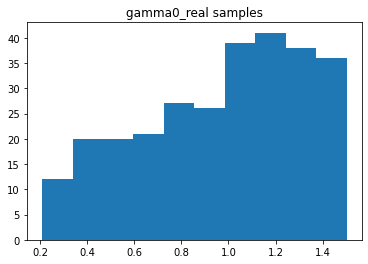

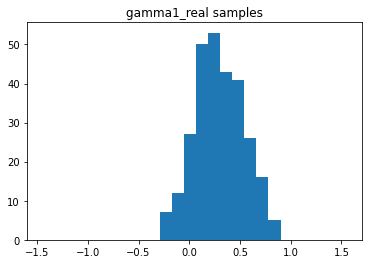

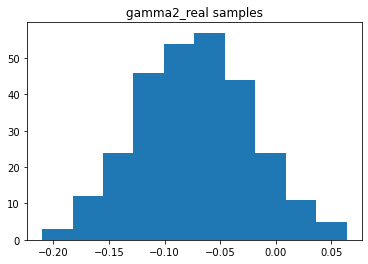

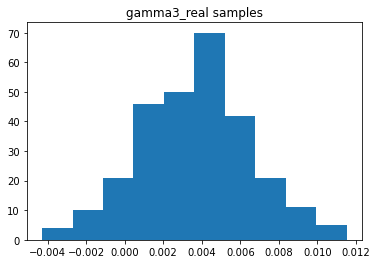

In [86]:
plt.hist(sd_gamma0_real[0:280])
plt.title("gamma0_real samples")
plt.show()

plt.hist(sd_gamma1_real[0:280])
plt.title("gamma1_real samples")
#prior range
plt.xlim(-1.6, 1.7)
plt.show()

plt.hist(sd_gamma2_real[0:280])
plt.title("gamma2_real samples")
plt.show()

plt.hist(sd_gamma3_real[0:280])
plt.title("gamma3_real samples")
plt.show()

In [10]:

#normalize outputs

#γ0 ∈ [0.2, 2.0]
#γ1 ∈ [−1.6, 1.7]
#γ2 ∈ [−0.6, 0.6]
#γ3 ∈ [−0.02, 0.02]

sd_gamma0 = ( sd_gamma0_real - 0.2 ) / ( 2.0 - 0.2 )
sd_gamma1 = sd_gamma1_real/1.7
sd_gamma2 = sd_gamma2_real/0.6
sd_gamma3 = sd_gamma3_real/0.02


Histogram of normalized outputs

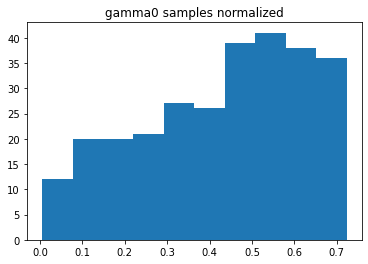

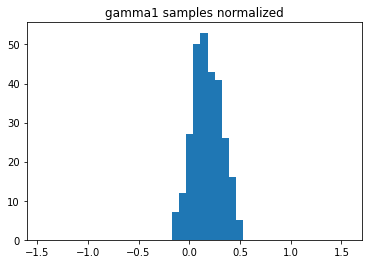

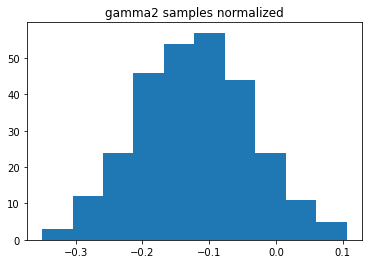

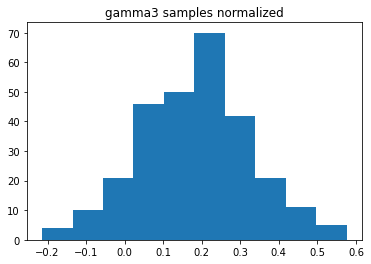

In [87]:
plt.hist(sd_gamma0[0:280])
plt.title("gamma0 samples normalized")
#print(np.min(sd_gamma0))
#print(np.max(sd_gamma0))
plt.show()

plt.hist(sd_gamma1[0:280])
plt.title("gamma1 samples normalized")
#print(np.min(sd_gamma1))
#print(np.max(sd_gamma1))
plt.xlim(-1.6, 1.7)
plt.show()

plt.hist(sd_gamma2[0:280])
plt.title("gamma2 samples normalized")
#print(np.min(sd_gamma2))
#print(np.max(sd_gamma2))
plt.show()

plt.hist(sd_gamma3[0:280])
plt.title("gamma3 samples normalized")
#print(np.min(sd_gamma3))
#print(np.max(sd_gamma3))
plt.show()

In [12]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 8 ] * 350)
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(350, 8)


In [13]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = sd_gamma3[i]
    

In [57]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'gamma3']
print(data)

           m1        m2          l1           l2    gamma0    gamma1  \
0    2.356079  1.050408   86.742387  7564.514274  0.573303  0.169377   
1    1.835028  1.645969  143.696599   304.007610  0.247882  0.363438   
2    1.560813  1.397909   53.916191   116.756380  0.026970  0.272407   
3    1.494956  1.323438  466.916534   934.746557  0.421740  0.079028   
4    1.526318  1.099764  288.106098  1692.777747  0.093814  0.381883   
..        ...       ...         ...          ...       ...       ...   
345  1.793659  1.324266  489.011516  2505.901820  0.580751  0.181717   
346  1.937342  1.670398   95.801566   306.240963  0.513729  0.105156   
347  2.039313  1.527568   44.843342   366.158904  0.490871  0.019230   
348  2.300180  2.271107   76.301166    85.538663  0.575036  0.165086   
349  0.000000  0.000000    0.000000     0.000000  0.000000  0.000000   

       gamma2    gamma3  
0   -0.154291  0.280229  
1   -0.255271  0.439465  
2   -0.092208  0.065249  
3   -0.021606 -0.030625  
4   -

split the data without shuffling the data

In [65]:
# we want the first 280 samples to = train
# we want the last 70 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
train = data.iloc[:280,:]
test = data.iloc[280:,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

train_stats = train.describe()

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('gamma3')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)


Shape of new dataframes - (280, 8) , (70, 8)


In [66]:
#whitening
#norm_train_X = whiten(train)
#norm_test_X = whiten(test)

norm_train_X = train
norm_test_X = test

In [67]:
# build the model using the functional syntax

# output will be fed directly from the previous dense layer

act = 'tanh'

input_layer = Input(shape=(len(train .columns),))

#norm = normalizer(input_layer)

first_dense = Dense(units='128', activation=act)(input_layer)
second_dense = Dense(units='128', activation=act)(first_dense)
third_dense = Dense(units='128', activation=act)(second_dense)
fourth_dense = Dense(units='128', activation=act)(third_dense)
fifth_dense = Dense(units='128', activation=act)(fourth_dense)
sixth_dense = Dense(units='128', activation=act)(fifth_dense)
seventh_dense = Dense(units='128', activation=act)(sixth_dense)
eight_dense = Dense(units='128', activation=act)(seventh_dense)
ninth_dense = Dense(units='128', activation=act)(eight_dense)
    
tenth_dense = Dense(units='128', activation=act)(ninth_dense)
eleventh_dense = Dense(units='128', activation=act)(tenth_dense)
twelth_dense = Dense(units='128', activation=act)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=act)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=act)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=act)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=act)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=act)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=act)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=act)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=act)(nineteenth_dense)
tf_dense = Dense(units='128', activation=act)(twentieth_dense)
ts_dense = Dense(units='128', activation=act)(tf_dense)
tt_dense = Dense(units='128', activation=act)(ts_dense)
tfo_dense = Dense(units='128', activation=act)(tt_dense)
tfi_dense = Dense(units='128', activation=act)(tfo_dense)
ts_dense = Dense(units='128', activation=act)(tfi_dense)
tse_dense = Dense(units='128', activation=act)(ts_dense)
te_dense = Dense(units='128', activation=act)(tse_dense)
tn_dense = Dense(units='128', activation=act)(te_dense)


gamma0_output = Dense(units='1', activation='sigmoid', name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=act)(tn_dense)

ths_dense = Dense(units='128', activation=act)(thf_dense)
tht_dense = Dense(units='128', activation=act)(ths_dense)
thfo_dense = Dense(units='128', activation=act)(tht_dense)
thfi_dense = Dense(units='128', activation=act)(thfo_dense)
ths_dense = Dense(units='128', activation=act)(thfi_dense)
thse_dense = Dense(units='128', activation=act)(ths_dense)
the_dense = Dense(units='128', activation=act)(thse_dense)
thn_dense = Dense(units='128', activation=act)(the_dense)

gamma1_output = Dense(units='1', activation=act, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=act)(thn_dense)

fof_dense = Dense(units='128', activation=act)(fo_dense)
fos_dense = Dense(units='128', activation=act)(fof_dense)
fot_dense = Dense(units='128', activation=act)(fos_dense)
fofo_dense = Dense(units='128', activation=act)(fot_dense)
fofi_dense = Dense(units='128', activation=act)(fofo_dense)

gamma2_output = Dense(units='1', activation=act, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=act)(fofi_dense)

fose_dense = Dense(units='128', activation=act)(fos_dense)
foe_dense = Dense(units='128', activation=act)(fose_dense)
fon_dense = Dense(units='128', activation=act)(foe_dense)
fif_dense = Dense(units='128', activation=act)(fon_dense)

gamma3_output = Dense(units='1', activation=act, name='gamma3_output')(fon_dense)

model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, gamma3_output])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_49 (Dense)               (None, 128)          640         ['input_2[0][0]']                
                                                                                                  
 dense_50 (Dense)               (None, 128)          16512       ['dense_49[0][0]']               
                                                                                                  
 dense_51 (Dense)               (None, 128)          16512       ['dense_50[0][0]']               
                                                                                            

 dense_88 (Dense)               (None, 128)          4224        ['dense_87[0][0]']               
                                                                                                  
 dense_89 (Dense)               (None, 128)          16512       ['dense_88[0][0]']               
                                                                                                  
 dense_90 (Dense)               (None, 128)          16512       ['dense_89[0][0]']               
                                                                                                  
 dense_91 (Dense)               (None, 128)          16512       ['dense_90[0][0]']               
                                                                                                  
 dense_92 (Dense)               (None, 128)          16512       ['dense_91[0][0]']               
                                                                                                  
 dense_93 

In [68]:
#plot_model(model, to_file='V5_combinedmll.png', show_shapes=True, show_layer_names=True)

In [69]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'gamma3_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma3_output': tf.keras.metrics.MeanSquaredError()
                      })


endmetric = "mean_squared_error"


In [70]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])

Epoch 1/200
23/23 [==============================] - 4s 37ms/step - loss: 0.1222 - gamma0_output_loss: 0.0387 - gamma1_output_loss: 0.0456 - gamma2_output_loss: 0.0132 - gamma3_output_loss: 0.0247 - gamma0_output_mean_squared_error: 0.0387 - gamma1_output_mean_squared_error: 0.0456 - gamma2_output_mean_squared_error: 0.0132 - gamma3_output_mean_squared_error: 0.0247 - val_loss: 0.1257 - val_gamma0_output_loss: 0.0505 - val_gamma1_output_loss: 0.0293 - val_gamma2_output_loss: 0.0188 - val_gamma3_output_loss: 0.0272 - val_gamma0_output_mean_squared_error: 0.0505 - val_gamma1_output_mean_squared_error: 0.0293 - val_gamma2_output_mean_squared_error: 0.0188 - val_gamma3_output_mean_squared_error: 0.0272
Epoch 2/200
23/23 [==============================] - 0s 18ms/step - loss: 0.0956 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 0.0268 - gamma2_output_loss: 0.0095 - gamma3_output_loss: 0.0226 - gamma0_output_mean_squared_error: 0.0367 - gamma1_output_mean_squared_error: 0.0268 - gamma2_

Epoch 13/200
23/23 [==============================] - 0s 18ms/step - loss: 0.0850 - gamma0_output_loss: 0.0362 - gamma1_output_loss: 0.0205 - gamma2_output_loss: 0.0072 - gamma3_output_loss: 0.0210 - gamma0_output_mean_squared_error: 0.0362 - gamma1_output_mean_squared_error: 0.0205 - gamma2_output_mean_squared_error: 0.0072 - gamma3_output_mean_squared_error: 0.0210 - val_loss: 0.1196 - val_gamma0_output_loss: 0.0515 - val_gamma1_output_loss: 0.0300 - val_gamma2_output_loss: 0.0100 - val_gamma3_output_loss: 0.0281 - val_gamma0_output_mean_squared_error: 0.0515 - val_gamma1_output_mean_squared_error: 0.0300 - val_gamma2_output_mean_squared_error: 0.0100 - val_gamma3_output_mean_squared_error: 0.0281
Epoch 14/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0859 - gamma0_output_loss: 0.0364 - gamma1_output_loss: 0.0209 - gamma2_output_loss: 0.0074 - gamma3_output_loss: 0.0213 - gamma0_output_mean_squared_error: 0.0364 - gamma1_output_mean_squared_error: 0.0209 - gamma

Epoch 25/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0831 - gamma0_output_loss: 0.0350 - gamma1_output_loss: 0.0202 - gamma2_output_loss: 0.0071 - gamma3_output_loss: 0.0208 - gamma0_output_mean_squared_error: 0.0350 - gamma1_output_mean_squared_error: 0.0202 - gamma2_output_mean_squared_error: 0.0071 - gamma3_output_mean_squared_error: 0.0208 - val_loss: 0.1219 - val_gamma0_output_loss: 0.0542 - val_gamma1_output_loss: 0.0301 - val_gamma2_output_loss: 0.0100 - val_gamma3_output_loss: 0.0276 - val_gamma0_output_mean_squared_error: 0.0542 - val_gamma1_output_mean_squared_error: 0.0301 - val_gamma2_output_mean_squared_error: 0.0100 - val_gamma3_output_mean_squared_error: 0.0276
Epoch 26/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0831 - gamma0_output_loss: 0.0351 - gamma1_output_loss: 0.0201 - gamma2_output_loss: 0.0071 - gamma3_output_loss: 0.0208 - gamma0_output_mean_squared_error: 0.0351 - gamma1_output_mean_squared_error: 0.0201 - gamma

Epoch 37/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0828 - gamma0_output_loss: 0.0347 - gamma1_output_loss: 0.0201 - gamma2_output_loss: 0.0071 - gamma3_output_loss: 0.0208 - gamma0_output_mean_squared_error: 0.0347 - gamma1_output_mean_squared_error: 0.0201 - gamma2_output_mean_squared_error: 0.0071 - gamma3_output_mean_squared_error: 0.0208 - val_loss: 0.1207 - val_gamma0_output_loss: 0.0525 - val_gamma1_output_loss: 0.0305 - val_gamma2_output_loss: 0.0100 - val_gamma3_output_loss: 0.0277 - val_gamma0_output_mean_squared_error: 0.0525 - val_gamma1_output_mean_squared_error: 0.0305 - val_gamma2_output_mean_squared_error: 0.0100 - val_gamma3_output_mean_squared_error: 0.0277
Epoch 38/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0818 - gamma0_output_loss: 0.0343 - gamma1_output_loss: 0.0197 - gamma2_output_loss: 0.0071 - gamma3_output_loss: 0.0207 - gamma0_output_mean_squared_error: 0.0343 - gamma1_output_mean_squared_error: 0.0197 - gamma

Epoch 49/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0810 - gamma0_output_loss: 0.0340 - gamma1_output_loss: 0.0196 - gamma2_output_loss: 0.0070 - gamma3_output_loss: 0.0205 - gamma0_output_mean_squared_error: 0.0340 - gamma1_output_mean_squared_error: 0.0196 - gamma2_output_mean_squared_error: 0.0070 - gamma3_output_mean_squared_error: 0.0205 - val_loss: 0.1258 - val_gamma0_output_loss: 0.0536 - val_gamma1_output_loss: 0.0325 - val_gamma2_output_loss: 0.0106 - val_gamma3_output_loss: 0.0291 - val_gamma0_output_mean_squared_error: 0.0536 - val_gamma1_output_mean_squared_error: 0.0325 - val_gamma2_output_mean_squared_error: 0.0106 - val_gamma3_output_mean_squared_error: 0.0291
Epoch 50/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0801 - gamma0_output_loss: 0.0332 - gamma1_output_loss: 0.0193 - gamma2_output_loss: 0.0071 - gamma3_output_loss: 0.0205 - gamma0_output_mean_squared_error: 0.0332 - gamma1_output_mean_squared_error: 0.0193 - gamma

Epoch 61/200
23/23 [==============================] - 0s 18ms/step - loss: 0.0800 - gamma0_output_loss: 0.0333 - gamma1_output_loss: 0.0193 - gamma2_output_loss: 0.0070 - gamma3_output_loss: 0.0203 - gamma0_output_mean_squared_error: 0.0333 - gamma1_output_mean_squared_error: 0.0193 - gamma2_output_mean_squared_error: 0.0070 - gamma3_output_mean_squared_error: 0.0203 - val_loss: 0.1237 - val_gamma0_output_loss: 0.0522 - val_gamma1_output_loss: 0.0318 - val_gamma2_output_loss: 0.0106 - val_gamma3_output_loss: 0.0292 - val_gamma0_output_mean_squared_error: 0.0522 - val_gamma1_output_mean_squared_error: 0.0318 - val_gamma2_output_mean_squared_error: 0.0106 - val_gamma3_output_mean_squared_error: 0.0292
Epoch 62/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0802 - gamma0_output_loss: 0.0334 - gamma1_output_loss: 0.0193 - gamma2_output_loss: 0.0070 - gamma3_output_loss: 0.0205 - gamma0_output_mean_squared_error: 0.0334 - gamma1_output_mean_squared_error: 0.0193 - gamma

Epoch 73/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0796 - gamma0_output_loss: 0.0334 - gamma1_output_loss: 0.0192 - gamma2_output_loss: 0.0069 - gamma3_output_loss: 0.0200 - gamma0_output_mean_squared_error: 0.0334 - gamma1_output_mean_squared_error: 0.0192 - gamma2_output_mean_squared_error: 0.0069 - gamma3_output_mean_squared_error: 0.0200 - val_loss: 0.1293 - val_gamma0_output_loss: 0.0584 - val_gamma1_output_loss: 0.0319 - val_gamma2_output_loss: 0.0101 - val_gamma3_output_loss: 0.0288 - val_gamma0_output_mean_squared_error: 0.0584 - val_gamma1_output_mean_squared_error: 0.0319 - val_gamma2_output_mean_squared_error: 0.0101 - val_gamma3_output_mean_squared_error: 0.0288
Epoch 74/200
23/23 [==============================] - 0s 18ms/step - loss: 0.0788 - gamma0_output_loss: 0.0325 - gamma1_output_loss: 0.0190 - gamma2_output_loss: 0.0069 - gamma3_output_loss: 0.0204 - gamma0_output_mean_squared_error: 0.0325 - gamma1_output_mean_squared_error: 0.0190 - gamma

Epoch 85/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0780 - gamma0_output_loss: 0.0325 - gamma1_output_loss: 0.0188 - gamma2_output_loss: 0.0068 - gamma3_output_loss: 0.0199 - gamma0_output_mean_squared_error: 0.0325 - gamma1_output_mean_squared_error: 0.0188 - gamma2_output_mean_squared_error: 0.0068 - gamma3_output_mean_squared_error: 0.0199 - val_loss: 0.1304 - val_gamma0_output_loss: 0.0569 - val_gamma1_output_loss: 0.0334 - val_gamma2_output_loss: 0.0106 - val_gamma3_output_loss: 0.0295 - val_gamma0_output_mean_squared_error: 0.0569 - val_gamma1_output_mean_squared_error: 0.0334 - val_gamma2_output_mean_squared_error: 0.0106 - val_gamma3_output_mean_squared_error: 0.0295
Epoch 86/200
23/23 [==============================] - 0s 13ms/step - loss: 0.0778 - gamma0_output_loss: 0.0327 - gamma1_output_loss: 0.0185 - gamma2_output_loss: 0.0067 - gamma3_output_loss: 0.0199 - gamma0_output_mean_squared_error: 0.0327 - gamma1_output_mean_squared_error: 0.0185 - gamma

Epoch 97/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0772 - gamma0_output_loss: 0.0323 - gamma1_output_loss: 0.0184 - gamma2_output_loss: 0.0068 - gamma3_output_loss: 0.0198 - gamma0_output_mean_squared_error: 0.0323 - gamma1_output_mean_squared_error: 0.0184 - gamma2_output_mean_squared_error: 0.0068 - gamma3_output_mean_squared_error: 0.0198 - val_loss: 0.1299 - val_gamma0_output_loss: 0.0543 - val_gamma1_output_loss: 0.0334 - val_gamma2_output_loss: 0.0113 - val_gamma3_output_loss: 0.0310 - val_gamma0_output_mean_squared_error: 0.0543 - val_gamma1_output_mean_squared_error: 0.0334 - val_gamma2_output_mean_squared_error: 0.0113 - val_gamma3_output_mean_squared_error: 0.0310
Epoch 98/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0774 - gamma0_output_loss: 0.0320 - gamma1_output_loss: 0.0186 - gamma2_output_loss: 0.0068 - gamma3_output_loss: 0.0200 - gamma0_output_mean_squared_error: 0.0320 - gamma1_output_mean_squared_error: 0.0186 - gamma

Epoch 109/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0754 - gamma0_output_loss: 0.0313 - gamma1_output_loss: 0.0181 - gamma2_output_loss: 0.0065 - gamma3_output_loss: 0.0194 - gamma0_output_mean_squared_error: 0.0313 - gamma1_output_mean_squared_error: 0.0181 - gamma2_output_mean_squared_error: 0.0065 - gamma3_output_mean_squared_error: 0.0194 - val_loss: 0.1468 - val_gamma0_output_loss: 0.0657 - val_gamma1_output_loss: 0.0377 - val_gamma2_output_loss: 0.0120 - val_gamma3_output_loss: 0.0314 - val_gamma0_output_mean_squared_error: 0.0657 - val_gamma1_output_mean_squared_error: 0.0377 - val_gamma2_output_mean_squared_error: 0.0120 - val_gamma3_output_mean_squared_error: 0.0314
Epoch 110/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0755 - gamma0_output_loss: 0.0315 - gamma1_output_loss: 0.0180 - gamma2_output_loss: 0.0066 - gamma3_output_loss: 0.0195 - gamma0_output_mean_squared_error: 0.0315 - gamma1_output_mean_squared_error: 0.0180 - gam

In [72]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, gamma3_loss, gamma3_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)

3/3 [==============================] - 0s 8ms/step - loss: 0.0699 - gamma0_output_loss: 0.0324 - gamma1_output_loss: 0.0144 - gamma2_output_loss: 0.0054 - gamma3_output_loss: 0.0178 - gamma0_output_mean_squared_error: 0.0324 - gamma1_output_mean_squared_error: 0.0144 - gamma2_output_mean_squared_error: 0.0054 - gamma3_output_mean_squared_error: 0.0178


In [73]:
#predictions = model.predict(norm_test_X.to_numpy())

new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions)


9/9 [==============================] - 0s 5ms/step


Histogram outputted gamma predictions, NOT un-normalized (still in normalized bounds)

0.29544204
0.5290847


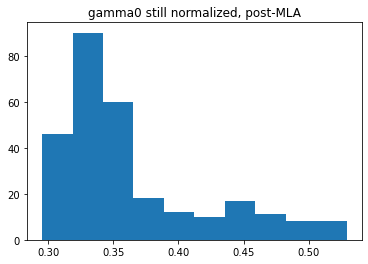

0.09451314
0.2577007


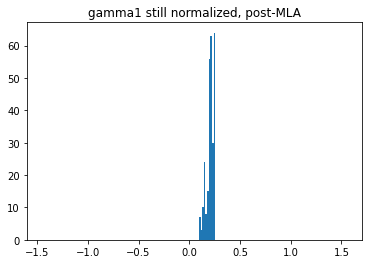

-0.14692166
-0.089022376


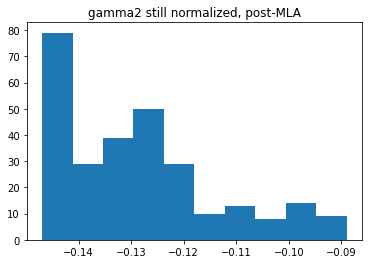

0.13136224
0.21779314


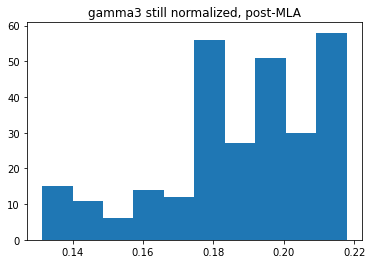

In [88]:
plt.hist(new_predictions[0])
plt.title("gamma0 still normalized, post-MLA")
print(np.min(new_predictions[0]))
print(np.max(new_predictions[0]))
plt.show()

plt.hist(new_predictions[1])
print(np.min(new_predictions[1]))
print(np.max(new_predictions[1]))
plt.title("gamma1 still normalized, post-MLA")
plt.xlim(-1.6, 1.7)

plt.show()

plt.hist(new_predictions[2])
print(np.min(new_predictions[2]))
print(np.max(new_predictions[2]))
plt.title("gamma2 still normalized, post-MLA")
plt.show()

plt.hist(new_predictions[3])
print(np.min(new_predictions[3]))
print(np.max(new_predictions[3]))
plt.title("gamma3 still normalized, post-MLA")
plt.show()

Histogram outputted gamma predictions, un-normalized

-0.08754398
0.79369545


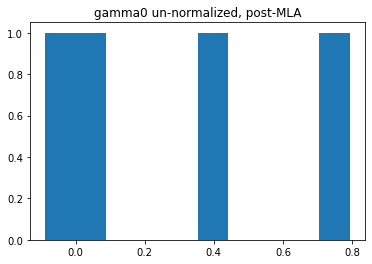

-0.08711989
0.8709685


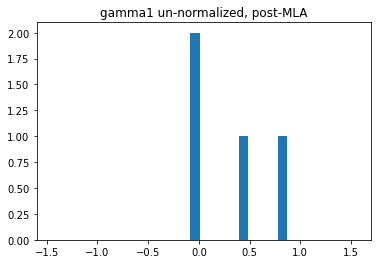

-0.08725166
0.8190148


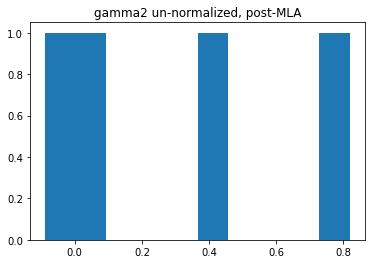

-0.07468459
0.7640385


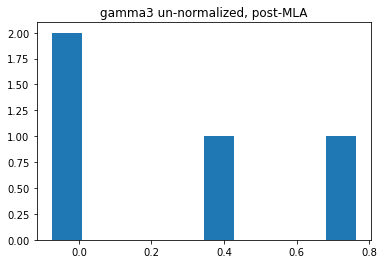

In [89]:
plt.hist(predictions[0])
plt.title("gamma0 un-normalized, post-MLA")
print(np.min(predictions[0]))
print(np.max(predictions[0]))
plt.show()

plt.hist(predictions[1])
print(np.min(predictions[1]))
print(np.max(predictions[1]))
plt.title("gamma1 un-normalized, post-MLA")
plt.xlim(-1.6, 1.7)

plt.show()

plt.hist(predictions[2])
print(np.min(predictions[2]))
print(np.max(predictions[2]))
plt.title("gamma2 un-normalized, post-MLA")
plt.show()

plt.hist(predictions[3])
print(np.min(predictions[3]))
print(np.max(predictions[3]))
plt.title("gamma3 un-normalized, post-MLA")
plt.show()

In [76]:
len(predictions)

280

# EOS

In [77]:
length = len(predictions)

Progress : 0 / 280, 0.00%
Progress : 35 / 280, 12.50%
Progress : 70 / 280, 25.00%
Progress : 105 / 280, 37.50%
Progress : 140 / 280, 50.00%
Progress : 175 / 280, 62.50%
Progress : 210 / 280, 75.00%
Progress : 245 / 280, 87.50%


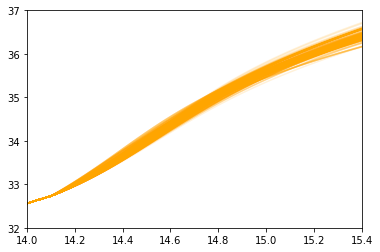

In [78]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):
    
    gam0 = float(predictions[i][0])
    gam1 = float(predictions[i][1])
    gam2 = float(predictions[i][2])
    gam3 = float(predictions[i][3])
    
    if i%35==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    eos = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(gam0,gam1,gam2,gam3)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='orange',alpha=0.15)

plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Actual EOS

In [79]:
length = len(predictions)

In [80]:
length

280

Progress : 0 / 280, 0.00%
Progress : 25 / 280, 8.93%
Progress : 50 / 280, 17.86%
Progress : 75 / 280, 26.79%
Progress : 100 / 280, 35.71%
Progress : 125 / 280, 44.64%
Progress : 150 / 280, 53.57%
Progress : 175 / 280, 62.50%
Progress : 200 / 280, 71.43%
Progress : 225 / 280, 80.36%
Progress : 250 / 280, 89.29%
Progress : 275 / 280, 98.21%


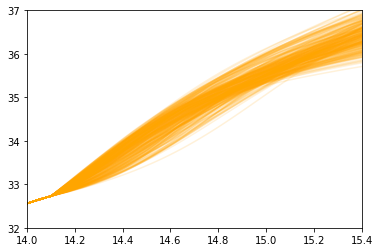

In [81]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):
    
    gam0 = float(sd_gamma0_real[i])
    gam1 = float(sd_gamma1_real[i])
    gam2 = float(sd_gamma2_real[i])
    gam3 = float(sd_gamma3_real[i])
    
    if i%25==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    eos = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(gam0,gam1,gam2,gam3)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='orange',alpha=0.15)

plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [27]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'gamma3_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'gamma3_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_gamma3_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_gamma3_output_mean_squared_error'])

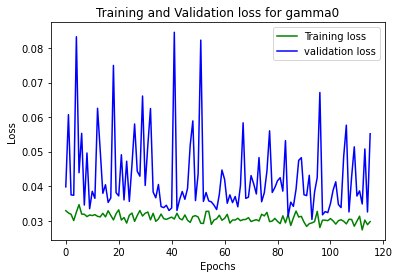

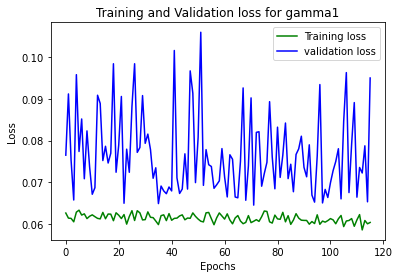

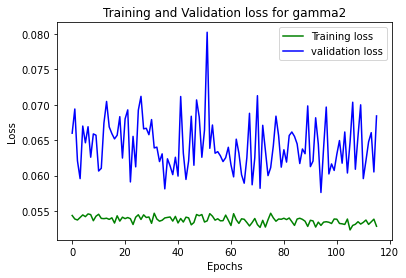

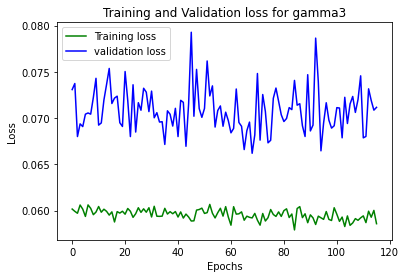

In [28]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma3 values
loss_train = history.history['gamma3_output_loss']
loss_val = history.history['val_gamma3_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metric

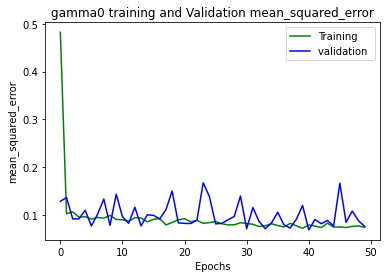

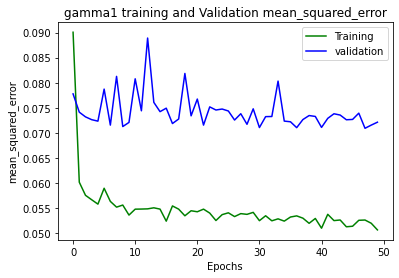

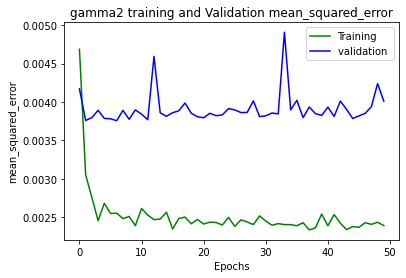

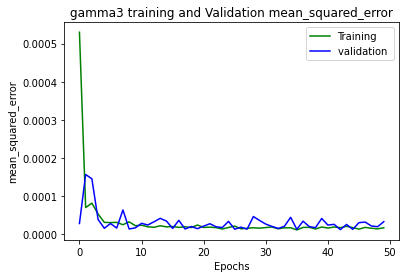

In [42]:
val = 'val_'
gam0out = 'gamma0_output_'
gam1out = 'gamma1_output_'
gam2out = 'gamma2_output_'
gam3out = 'gamma3_output_'

ac_train = history.history[gam0out + endmetric]
ac_val = history.history[val + gam0out + endmetric]
plt.plot(ac_train, 'g', label='Training')
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma0 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()



ac_train = history.history[gam1out + endmetric]
ac_val = history.history[val + gam1out + endmetric]
plt.plot(ac_train, 'g', label='Training')
plt.plot(ac_val, 'b', label='validation')
plt.title('gamma1 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()

ac_train = history.history[gam2out + endmetric]
ac_val = history.history[val + gam2out + endmetric]
plt.plot(ac_train, 'g', label='Training ',)
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma2 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()

ac_train = history.history[gam3out + endmetric]
ac_val = history.history[val + gam3out + endmetric]
plt.plot(ac_train, 'g', label='Training ')
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma3 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()